In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [7]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [12]:
movie_names.values()[:5]

['Toy Story (1995)',
 'Jumanji (1995)',
 'Grumpier Old Men (1995)',
 'Waiting to Exhale (1995)',
 'Father of the Bride Part II (1995)']

In [13]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [16]:
print(users[:5])
print(movies[:5])

[1 2 3 4 5]
[  31 1029 1061 1129 1172]


In [17]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [18]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [19]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [20]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [21]:
n_factors = 50

In [22]:
np.random.seed = 42

Randomly split into training and validation.

In [23]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [24]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [25]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [26]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [27]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [28]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [29]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [30]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [31]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/1
80199/80199 [==============================] - 6s - loss: 10.1237 - val_loss: 3.9054


In [32]:
model.optimizer.lr=0.01

In [33]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/3
80199/80199 [==============================] - 6s - loss: 3.1845 - val_loss: 1.9978
Epoch 2/3
80199/80199 [==============================] - 6s - loss: 2.4268 - val_loss: 1.6289
Epoch 3/3
80199/80199 [==============================] - 6s - loss: 2.2488 - val_loss: 1.4945


In [34]:
model.optimizer.lr=0.001

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/6
80199/80199 [==============================] - 6s - loss: 2.1778 - val_loss: 1.4401
Epoch 2/6
80199/80199 [==============================] - 6s - loss: 2.1351 - val_loss: 1.4279
Epoch 3/6
80199/80199 [==============================] - 6s - loss: 2.1029 - val_loss: 1.4227
Epoch 4/6
80199/80199 [==============================] - 6s - loss: 2.0772 - val_loss: 1.4190
Epoch 5/6
80199/80199 [==============================] - 6s - loss: 2.0536 - val_loss: 1.4167
Epoch 6/6
80199/80199 [==============================] - 6s - loss: 2.0364 - val_loss: 1.4150


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [36]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [37]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [38]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [39]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [40]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [41]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/1
80199/80199 [==============================] - 6s - loss: 8.6915 - val_loss: 3.0277


In [42]:
model.optimizer.lr=0.01

In [43]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/6
80199/80199 [==============================] - 6s - loss: 2.5727 - val_loss: 1.6092
Epoch 2/6
80199/80199 [==============================] - 6s - loss: 2.0119 - val_loss: 1.3241
Epoch 3/6
80199/80199 [==============================] - 6s - loss: 1.8588 - val_loss: 1.2147
Epoch 4/6
80199/80199 [==============================] - 6s - loss: 1.7655 - val_loss: 1.1516
Epoch 5/6
80199/80199 [==============================] - 6s - loss: 1.6834 - val_loss: 1.1179
Epoch 6/6
80199/80199 [==============================] - 6s - loss: 1.6043 - val_loss: 1.0875


In [44]:
model.optimizer.lr=0.001

In [45]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/10
80199/80199 [==============================] - 6s - loss: 1.5267 - val_loss: 1.0591
Epoch 2/10
80199/80199 [==============================] - 6s - loss: 1.4546 - val_loss: 1.0329
Epoch 3/10
80199/80199 [==============================] - 6s - loss: 1.3830 - val_loss: 1.0083
Epoch 4/10
80199/80199 [==============================] - 6s - loss: 1.3160 - val_loss: 0.9835
Epoch 5/10
80199/80199 [==============================] - 6s - loss: 1.2512 - val_loss: 0.9619
Epoch 6/10
80199/80199 [==============================] - 6s - loss: 1.1899 - val_loss: 0.9447
Epoch 7/10
80199/80199 [==============================] - 6s - loss: 1.1310 - val_loss: 0.9246
Epoch 8/10
80199/80199 [==============================] - 6s - loss: 1.0754 - val_loss: 0.9051
Epoch 9/10
80199/80199 [==============================] - 6s - loss: 1.0224 - val_loss: 0.8906
Epoch 10/10
80199/80199 [==============================] - 6s - loss: 0.9729 - val_loss: 0.8733

In [46]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/5
80199/80199 [==============================] - 6s - loss: 0.9254 - val_loss: 0.8608
Epoch 2/5
80199/80199 [==============================] - 6s - loss: 0.8818 - val_loss: 0.8493
Epoch 3/5
80199/80199 [==============================] - 6s - loss: 0.8411 - val_loss: 0.8384
Epoch 4/5
80199/80199 [==============================] - 6s - loss: 0.8035 - val_loss: 0.8273
Epoch 5/5
80199/80199 [==============================] - 6s - loss: 0.7692 - val_loss: 0.8189


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [47]:
model.save_weights(model_path+'bias.h5')

In [48]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [49]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.9427]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [50]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [51]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [52]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.54892421, 'Battlefield Earth (2000)'),
 (-0.20478602, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.15162049, 'Little Nicky (2000)'),
 (-0.14670429, 'Super Mario Bros. (1993)'),
 (-0.10408257, 'Speed 2: Cruise Control (1997)'),
 (-0.048414174, 'Police Academy 6: City Under Siege (1989)'),
 (-0.04252946, 'Jaws 3-D (1983)'),
 (-0.035995275, 'Spice World (1997)'),
 (-0.023784976, 'Blair Witch Project, The (1999)'),
 (0.028853888, 'Wild Wild West (1999)'),
 (0.044035915, 'Road to Wellville, The (1994)'),
 (0.046356563, 'Lake Placid (1999)'),
 (0.052425332, 'Haunting, The (1999)'),
 (0.052503258, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.061131489, 'Batman & Robin (1997)')]

In [53]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4099336, 'Perks of Being a Wallflower, The (2012)'),
 (1.406154, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.4022821, 'Rush (2013)'),
 (1.379029, 'Argo (2012)'),
 (1.3700737, 'General, The (1926)'),
 (1.3546933, 'Shawshank Redemption, The (1994)'),
 (1.3490055, 'Cyrano de Bergerac (1990)'),
 (1.3469445, 'Captain America: The Winter Soldier (2014)'),
 (1.3353938, 'Persuasion (1995)'),
 (1.3201619,
  'Fog of War: Eleven Lessons from the Life of Robert S. McNamara, The (2003)'),
 (1.3086364, 'The Theory of Everything (2014)'),
 (1.2940981, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2929524, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.2911285, 'Big Night (1996)'),
 (1.2890757, "Amores Perros (Love's a Bitch) (2000)")]

We can now do the same thing for the embeddings.

In [54]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [56]:
fac0 = movie_pca[0]

In [57]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.016168289, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.013944457, 'Anaconda (1997)'),
 (0.0078342734,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (0.0065423651, 'Howard the Duck (1986)'),
 (0.0061020213, 'Daredevil (2003)'),
 (0.006082152, '2012 (2009)'),
 (0.0060501699, 'Barb Wire (1996)'),
 (0.0060057435, 'Godzilla (1998)'),
 (0.0055677448, 'Wild Wild West (1999)'),
 (0.0052653365, 'Police Academy 4: Citizens on Patrol (1987)')]

In [59]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.051533803, "Schindler's List (1993)"),
 (-0.051485043, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.050933328, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.050930109, 'American Beauty (1999)'),
 (-0.049797025, 'Usual Suspects, The (1995)'),
 (-0.049263403, 'Godfather, The (1972)'),
 (-0.048572581, 'Godfather: Part II, The (1974)'),
 (-0.048467547, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.04822154, 'Shawshank Redemption, The (1994)'),
 (-0.047750078, 'Wallace & Gromit: A Close Shave (1995)')]

In [60]:
fac1 = movie_pca[1]

In [61]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [62]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.11251035, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.090774164, 'Stargate (1994)'),
 (0.089283094, 'Armageddon (1998)'),
 (0.078068174, 'Waterworld (1995)'),
 (0.073744692, 'Speed (1994)'),
 (0.072999738, 'Star Trek: First Contact (1996)'),
 (0.072841845, 'Braveheart (1995)'),
 (0.0723942, 'Jurassic Park (1993)'),
 (0.071895733, 'Ghost (1990)'),
 (0.070661515, 'Titanic (1997)')]

In [63]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.063395992, 'Brokeback Mountain (2005)'),
 (-0.063095145, 'Annie Hall (1977)'),
 (-0.062786974, 'Manhattan (1979)'),
 (-0.061466202, 'Clockwork Orange, A (1971)'),
 (-0.05991789, '8 1/2 (8\xc2\xbd) (1963)'),
 (-0.057729416, 'Wild Bunch, The (1969)'),
 (-0.057541411, 'City Lights (1931)'),
 (-0.056762099, 'Apocalypse Now (1979)'),
 (-0.05579748, 'Harold and Maude (1971)'),
 (-0.054144789, 'Bringing Up Baby (1938)')]

In [64]:
fac2 = movie_pca[2]

In [65]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [66]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07531935, 'Bend It Like Beckham (2002)'),
 (0.071932875, 'Chicago (2002)'),
 (0.068079993, "You've Got Mail (1998)"),
 (0.065519772, 'Sabrina (1995)'),
 (0.061153982, 'Notebook, The (2004)'),
 (0.060023207, 'Sliding Doors (1998)'),
 (0.05608936, 'Double Jeopardy (1999)'),
 (0.056010734, 'Slumdog Millionaire (2008)'),
 (0.054100875, 'Elf (2003)'),
 (0.053635452, 'How to Lose a Guy in 10 Days (2003)')]

In [67]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10940533, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.10256357, 'Matrix, The (1999)'),
 (-0.10247827, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.097747996, 'Silence of the Lambs, The (1991)'),
 (-0.094696969, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.089405373, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.08688011, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.08585047, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.084303468, 'Terminator 2: Judgment Day (1991)'),
 (-0.082275964, 'Star Wars: Episode IV - A New Hope (1977)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [68]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

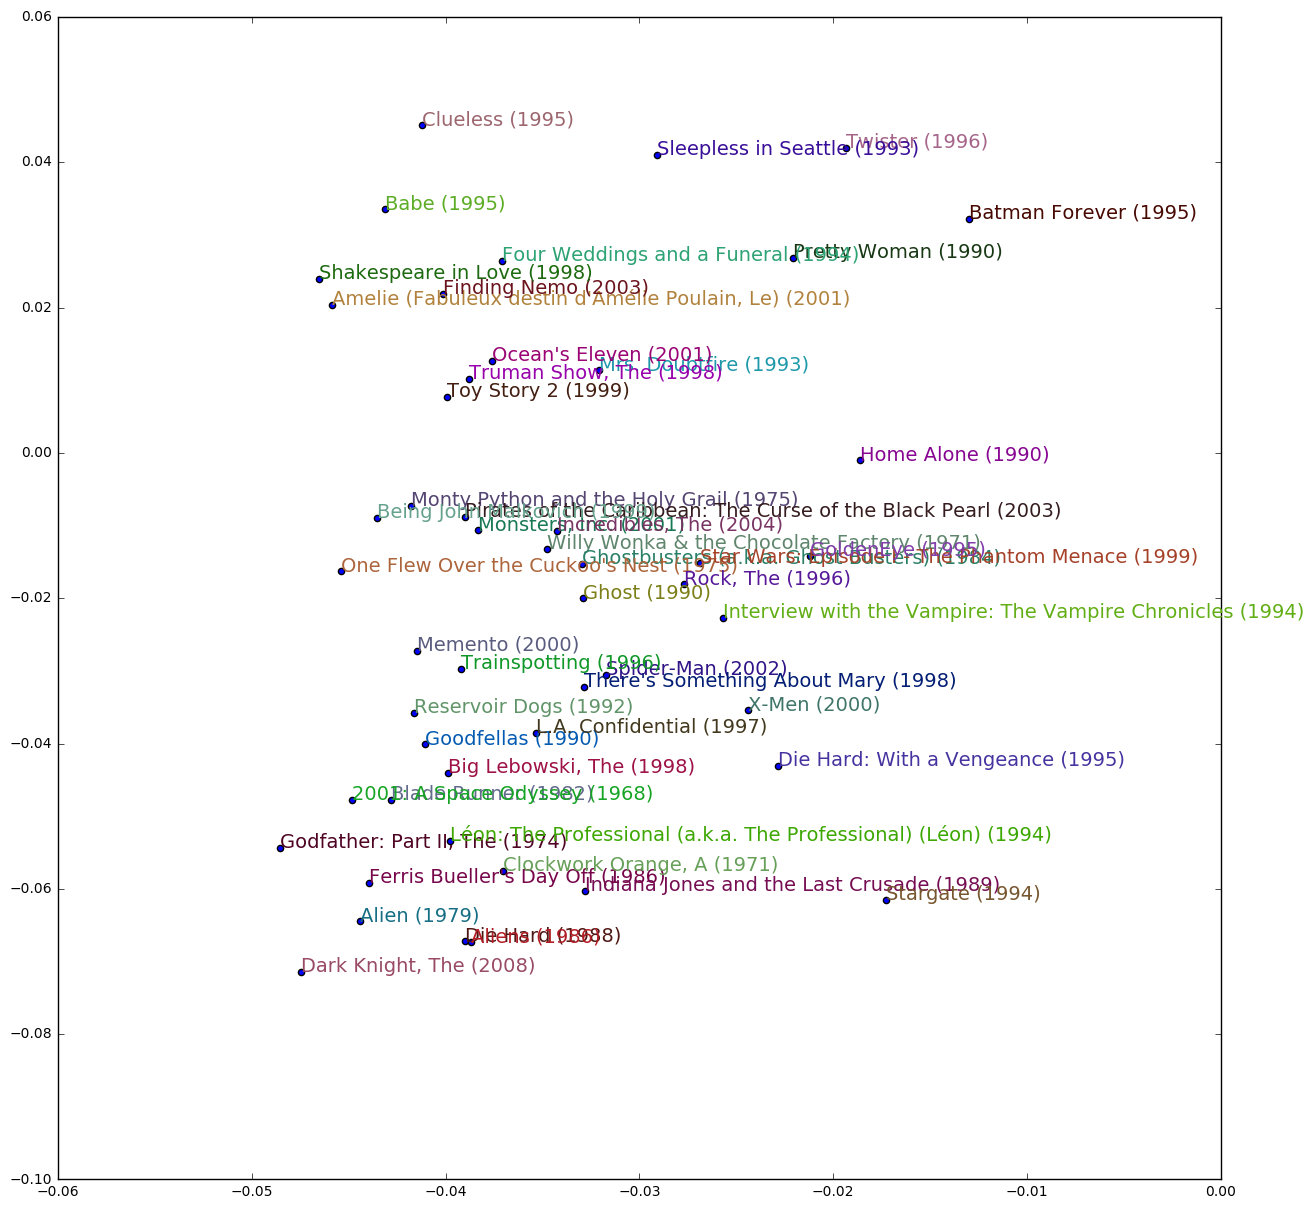

In [69]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [70]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [71]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [72]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80199 samples, validate on 19805 samples
Epoch 1/8
80199/80199 [==============================] - 7s - loss: 2.4955 - val_loss: 0.9116
Epoch 2/8
80199/80199 [==============================] - 7s - loss: 1.4426 - val_loss: 0.8270
Epoch 3/8
80199/80199 [==============================] - 7s - loss: 1.2050 - val_loss: 0.8241
Epoch 4/8
80199/80199 [==============================] - 7s - loss: 1.0286 - val_loss: 0.8013
Epoch 5/8
80199/80199 [==============================] - 7s - loss: 0.9191 - val_loss: 0.7962
Epoch 6/8
80199/80199 [==============================] - 7s - loss: 0.8542 - val_loss: 0.7927
Epoch 7/8
80199/80199 [==============================] - 7s - loss: 0.8226 - val_loss: 0.7923
Epoch 8/8
80199/80199 [==============================] - 7s - loss: 0.8114 - val_loss: 0.7880


This improves on our already impressive accuracy even further!